Import all Libraries

In [2]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import datasets
import sklearn.metrics as metrics
import pandas as pd

Load CIFAR10 Dataset and split to Train, Validation & Tests

100%|██████████| 170M/170M [00:10<00:00, 15.9MB/s]


Image shape: torch.Size([3, 32, 32])
labels: 10
6
9
9
4
1
1
2
7
8
3
4
7
7
2
9
9
9
3
2
6
4
3
6
6
2
6
3
5
4
0
0
9
1
3
4
0
3
7
3
3
5
2
2
7
1
1
1
2
2
0


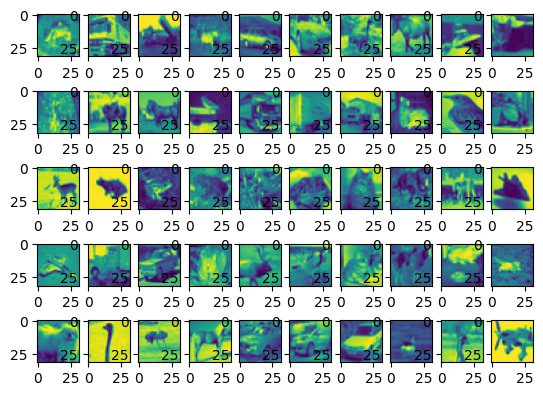

In [3]:
# download and apply transform
cifar = datasets.CIFAR10("/content/data", train=True, download=True, transform=transforms.ToTensor())
train_data = list(cifar)[:50000]

# find image shape and number of classess
img, label = train_data[0]

print("Image shape:", img.shape)
print("labels:", len(cifar.classes) )

# split dataset to train, validation and test sets
train_data, val_data, test_data = train_data[:35000], train_data[35000:45000], train_data[45000:]

# show the first 50 images in train data
for i, (img, label) in enumerate(train_data[:50]):
  plt.subplot(5, 10, i+1)
  plt.imshow(img[0,...])
  print(label)

plt.show()

Build Custom Softmax Model

In [4]:
# build a softmax model
class Softmax(torch.nn.Module):
  def __init__(self, features, labels):
    super(Softmax, self).__init__()
    self.linear = torch.nn.Linear(features, labels)

  def forward(self, x):
    pred = self.linear(x)
    return pred

# call the classfier and display initial parameters
model = Softmax(3072, 10)
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0125, -0.0077, -0.0066,  ..., -0.0107,  0.0125,  0.0004],
                      [-0.0177, -0.0116, -0.0173,  ...,  0.0022,  0.0013,  0.0013],
                      [ 0.0103, -0.0013, -0.0138,  ...,  0.0170, -0.0113, -0.0134],
                      ...,
                      [-0.0070, -0.0161,  0.0105,  ...,  0.0147,  0.0069,  0.0028],
                      [-0.0145, -0.0009,  0.0151,  ..., -0.0131, -0.0145,  0.0156],
                      [ 0.0081, -0.0112, -0.0093,  ..., -0.0112, -0.0015,  0.0072]])),
             ('linear.bias',
              tensor([ 0.0161,  0.0100,  0.0143, -0.0091, -0.0053,  0.0149,  0.0163,  0.0068,
                       0.0053,  0.0014]))])

Define Hyperparameters

In [5]:
# define loss, optimizer and dataloader for train, validation and test sets
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
batch_size = 20
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
epochs = 200

print("Loss Fn", criterion)
print("Batch Size", batch_size)
print("Epochs", epochs)
print("Optimizer", optimizer)

Loss Fn CrossEntropyLoss()
Batch Size 20
Epochs 200
Optimizer SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


Train sets, calculate loss, accuracy based on validation and test sets

Epoch 0, Loss: 1.93, Val Accuracy: 32.26, Test Accuracy: 32.50
Epoch 10, Loss: 1.71, Val Accuracy: 37.47, Test Accuracy: 37.40
Epoch 20, Loss: 1.71, Val Accuracy: 37.63, Test Accuracy: 36.04
Epoch 30, Loss: 1.67, Val Accuracy: 37.51, Test Accuracy: 37.84
Epoch 40, Loss: 1.39, Val Accuracy: 39.30, Test Accuracy: 39.62
Epoch 50, Loss: 1.54, Val Accuracy: 34.63, Test Accuracy: 34.40
Epoch 60, Loss: 1.38, Val Accuracy: 36.79, Test Accuracy: 37.28
Epoch 70, Loss: 1.49, Val Accuracy: 36.31, Test Accuracy: 35.94
Epoch 80, Loss: 1.75, Val Accuracy: 36.63, Test Accuracy: 37.26
Epoch 90, Loss: 1.91, Val Accuracy: 38.79, Test Accuracy: 39.96
Epoch 100, Loss: 1.37, Val Accuracy: 37.11, Test Accuracy: 37.54
Epoch 110, Loss: 1.36, Val Accuracy: 36.77, Test Accuracy: 36.42
Epoch 120, Loss: 1.47, Val Accuracy: 38.55, Test Accuracy: 39.30
Epoch 130, Loss: 2.22, Val Accuracy: 37.21, Test Accuracy: 36.48
Epoch 140, Loss: 1.80, Val Accuracy: 37.90, Test Accuracy: 37.50
Epoch 150, Loss: 1.89, Val Accuracy:

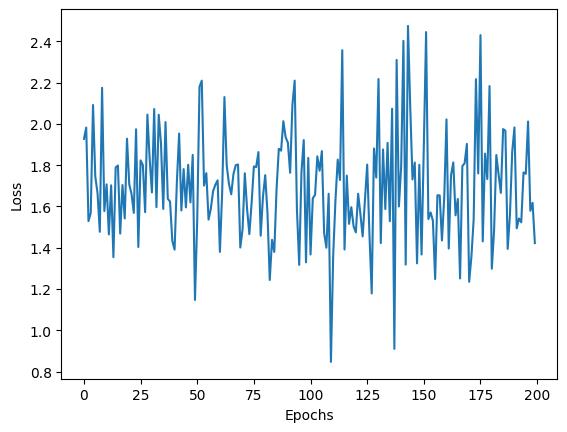

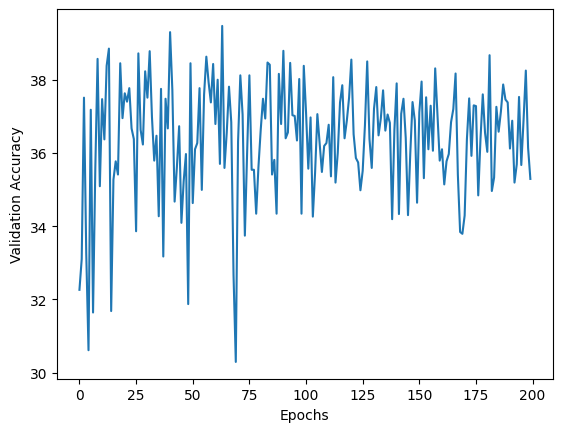

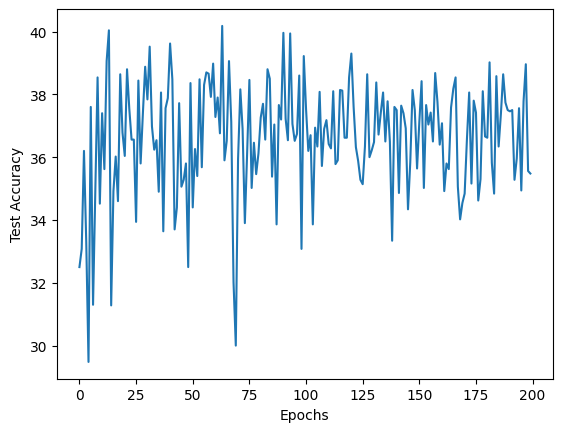

In [6]:
# define loss and accuracy
Loss = []
val_acc = []
test_acc = []
test_predicted_labels = []
test_true_labels = []

for epoch in range(epochs):
  for i, (images, labels) in enumerate(train_loader):
    optimizer.zero_grad()
    outputs = model(images.view(-1, 3072))
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
  Loss.append(loss.item())

  # evaluate on validation and test data
  model.eval()
  val_correct = 0
  for images, labels in val_loader:
    outputs = model(images.view(-1, 3072))
    _, predicted = torch.max(outputs.data, 1)
    val_correct += (predicted == labels).sum()
  val_accuracy = 100 * (val_correct.item()) / len(val_data)
  val_acc.append(val_accuracy)

  # evaluate on test data
  model.eval()
  test_correct = 0
  for images, labels in test_loader:
    outputs = model(images.view(-1, 3072))
    _, predicted = torch.max(outputs.data, 1)
    test_correct += (predicted == labels).sum()
  test_accuracy = 100 * (test_correct.item()) / len(test_data)
  test_acc.append(test_accuracy)
  # get predicted and labels of test
  test_predicted_labels.extend(predicted.tolist())
  test_true_labels.extend(labels.tolist())

  # track epochss for each 10 iters
  if epoch % 10 == 0:
    print(f"Epoch {epoch}, Loss: {loss.item():.2f}, Val Accuracy: {val_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")

# visual representations
plt.plot(Loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# validation accuracy
plt.plot(val_acc)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

# test accuracy
plt.plot(test_acc)
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.show()

Use sklearn to print Classification report stats on Test Data

In [7]:
# classification report on test data
report = metrics.classification_report(test_true_labels, test_predicted_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

              precision    recall  f1-score     support
0              0.434146  0.414918  0.424315   429.00000
1              0.403423  0.434211  0.418251   380.00000
2              0.248021  0.240409  0.244156   391.00000
3              0.231183  0.227513  0.229333   378.00000
4              0.336310  0.295039  0.314325   383.00000
5              0.305263  0.267281  0.285012   434.00000
6              0.425197  0.424084  0.424640   382.00000
7              0.385390  0.410188  0.397403   373.00000
8              0.416826  0.527845  0.465812   413.00000
9              0.416465  0.393593  0.404706   437.00000
accuracy       0.364250  0.364250  0.364250     0.36425
macro avg      0.360222  0.363508  0.360795  4000.00000
weighted avg   0.361381  0.364250  0.361720  4000.00000


Add regularization using weight decays

In [41]:
# define your weights
weight_decay = [0.001, 0.01, 0.1, 0, 1]
best_accuracy = 0
best_weight_decay = None

for weight in weight_decay:
  # add weight to optimizer
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=weight)

  for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
      optimizer.zero_grad()
      outputs = model(images.view(-1, 3072))
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    Loss.append(loss.item())

    # evaluate on validation and test data
    model.eval()
    val_correct = 0
    for images, labels in val_loader:
      outputs = model(images.view(-1, 3072))
      _, predicted = torch.max(outputs.data, 1)
      val_correct += (predicted == labels).sum()
    val_accuracy = 100 * (val_correct.item()) / len(val_data)

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_weight_decay = weight
        print(f"Best accuracy: {best_accuracy:.2f}% with weight_decay={weight}")


print("Best weight_decay based on validation set:", best_weight_decay)

Best accuracy: 37.24% with weight_decay=0.001
Best accuracy: 38.93% with weight_decay=0.001
Best accuracy: 39.11% with weight_decay=0.001
Best accuracy: 39.37% with weight_decay=0.001
Best accuracy: 39.73% with weight_decay=0.001
Best accuracy: 39.74% with weight_decay=0
Best weight_decay based on validation set: 0


Retrain with Best Weight

Epoch 0, Loss: 1.74, Val Accuracy: 34.38, Test Accuracy: 33.70
Epoch 10, Loss: 1.73, Val Accuracy: 37.54, Test Accuracy: 37.92
Epoch 20, Loss: 1.45, Val Accuracy: 34.59, Test Accuracy: 35.32
Epoch 30, Loss: 1.74, Val Accuracy: 36.42, Test Accuracy: 37.72
Epoch 40, Loss: 2.01, Val Accuracy: 35.00, Test Accuracy: 36.14
Epoch 50, Loss: 1.73, Val Accuracy: 36.15, Test Accuracy: 36.20
Epoch 60, Loss: 1.74, Val Accuracy: 36.72, Test Accuracy: 36.64
Epoch 70, Loss: 1.89, Val Accuracy: 37.13, Test Accuracy: 37.56
Epoch 80, Loss: 1.92, Val Accuracy: 36.89, Test Accuracy: 36.94
Epoch 90, Loss: 1.34, Val Accuracy: 37.46, Test Accuracy: 37.46
Epoch 100, Loss: 1.21, Val Accuracy: 36.56, Test Accuracy: 36.32
Epoch 110, Loss: 2.14, Val Accuracy: 37.96, Test Accuracy: 38.12
Epoch 120, Loss: 1.83, Val Accuracy: 34.41, Test Accuracy: 35.18
Epoch 130, Loss: 1.85, Val Accuracy: 35.96, Test Accuracy: 36.78
Epoch 140, Loss: 1.26, Val Accuracy: 34.73, Test Accuracy: 35.48
Epoch 150, Loss: 1.30, Val Accuracy:

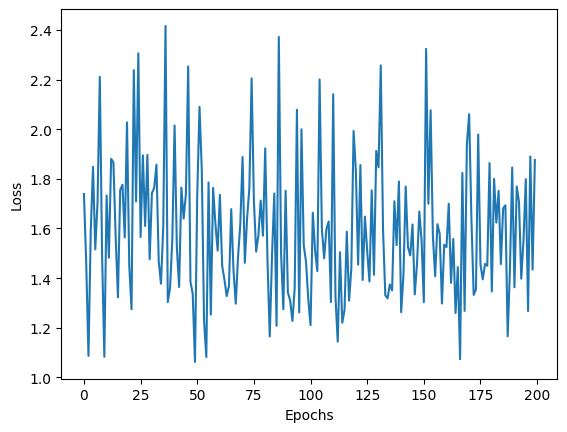

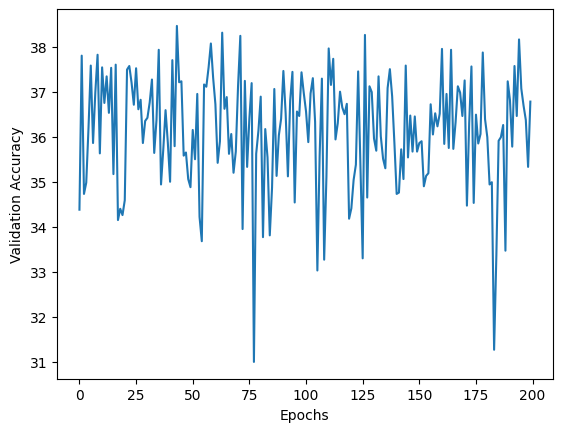

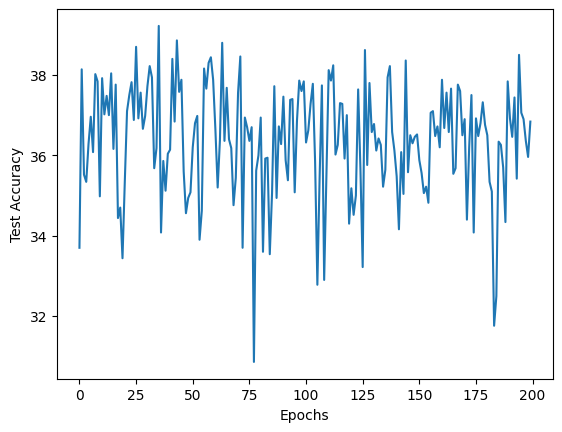

In [8]:
# define loss and accuracy
Loss = []
val_acc = []
test_acc = []
test_predicted_labels = []
test_true_labels = []
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0)

for epoch in range(epochs):
  for i, (images, labels) in enumerate(train_loader):
    optimizer.zero_grad()
    outputs = model(images.view(-1, 3072))
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
  Loss.append(loss.item())

  # evaluate on validation and test data
  model.eval()
  val_correct = 0
  for images, labels in val_loader:
    outputs = model(images.view(-1, 3072))
    _, predicted = torch.max(outputs.data, 1)
    val_correct += (predicted == labels).sum()
  val_accuracy = 100 * (val_correct.item()) / len(val_data)
  val_acc.append(val_accuracy)

  # evaluate on test data
  model.eval()
  test_correct = 0
  for images, labels in test_loader:
    outputs = model(images.view(-1, 3072))
    _, predicted = torch.max(outputs.data, 1)
    test_correct += (predicted == labels).sum()
  test_accuracy = 100 * (test_correct.item()) / len(test_data)
  test_acc.append(test_accuracy)
  # get predicted and labels of test
  test_predicted_labels.extend(predicted.tolist())
  test_true_labels.extend(labels.tolist())

  # track epochss for each 10 iters
  if epoch % 10 == 0:
    print(f"Epoch {epoch}, Loss: {loss.item():.2f}, Val Accuracy: {val_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")

# visual representations
plt.plot(Loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# validation accuracy
plt.plot(val_acc)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

# test accuracy
plt.plot(test_acc)
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.show()

Classification report using Best weight

In [9]:
# classification report on test data
report = metrics.classification_report(test_true_labels, test_predicted_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

              precision    recall  f1-score     support
0              0.382212  0.414062  0.397500   384.00000
1              0.366029  0.413514  0.388325   370.00000
2              0.313043  0.275510  0.293080   392.00000
3              0.264045  0.222222  0.241335   423.00000
4              0.296296  0.275132  0.285322   378.00000
5              0.276762  0.247086  0.261084   429.00000
6              0.370614  0.415233  0.391657   407.00000
7              0.355978  0.400612  0.376978   327.00000
8              0.516667  0.521008  0.518828   476.00000
9              0.419204  0.432367  0.425684   414.00000
accuracy       0.362750  0.362750  0.362750     0.36275
macro avg      0.356085  0.361675  0.357979  4000.00000
weighted avg   0.358516  0.362750  0.359755  4000.00000
